In [2]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

from cc_hardware.drivers.spads import SPADDataType, SPADSensorData
from cc_hardware.drivers.spads.pkl import PklSPADSensorConfig, PklSPADSensor
from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.utils.constants import C
from scipy.signal import find_peaks

In [3]:
pkl_path = Path("logs/2025-06-11/18-42-56/data.pkl")
assert pkl_path.exists()

config = PklReader(pkl_path).load(0)
assert "config" in config
config = config["config"]

background_sensor_config = PklSPADSensorConfig.create(
    pkl_path=pkl_path,
    loop=True,
    index=1,
    data_type=SPADDataType.HISTOGRAM | SPADDataType.POINT_CLOUD | SPADDataType.DISTANCE,
)
background_sensor = PklSPADSensor(background_sensor_config)
height, width = background_sensor.resolution
print(background_sensor_config)

datas = []
for i in range(1, len(background_sensor.handler)):
    data = background_sensor.accumulate(index=i)
    datas.append(data)
background_data = {
    SPADDataType.HISTOGRAM: np.mean([d[SPADDataType.HISTOGRAM] for d in datas], axis=0),
    SPADDataType.DISTANCE: np.mean([d[SPADDataType.DISTANCE] for d in datas], axis=0),
    SPADDataType.POINT_CLOUD: np.mean([d[SPADDataType.POINT_CLOUD] for d in datas], axis=0),
}

config: null
custom: {}
data_type: HISTOGRAM|DISTANCE|POINT_CLOUD
height: null
width: null
num_bins: null
fovx: null
fovy: null
timing_resolution: null
start_bin: null
subsample: null
pkl_path: logs/2025-06-11/18-42-56/data.pkl
index: 1
loop: true



In [ ]:
# pkl_path = Path("logs/2025-06-11/20-02-21/data.pkl")
pkl_path = Path("logs/2025-06-11/20-08-23/data.pkl")
# pkl_path = Path("logs/2025-06-11/20-11-04/data.pkl")
assert pkl_path.exists()

sensor_config = PklSPADSensorConfig.create(
    pkl_path=pkl_path,
    loop=True,
    index=1,
    data_type=SPADDataType.HISTOGRAM | SPADDataType.POINT_CLOUD | SPADDataType.DISTANCE,
)
sensor = PklSPADSensor(sensor_config)
height, width = sensor.resolution
print(sensor_config)

index = len(sensor.handler) - 1

config: null
custom: {}
data_type: HISTOGRAM|DISTANCE|POINT_CLOUD
height: null
width: null
num_bins: null
fovx: null
fovy: null
timing_resolution: null
start_bin: null
subsample: null
pkl_path: logs/2025-06-11/20-11-04/data.pkl
index: 1
loop: true



11.56 0


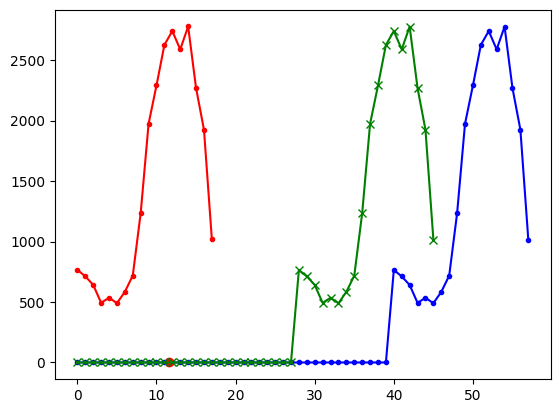

In [58]:
data = sensor.accumulate(index=index)
histograms = data[SPADDataType.HISTOGRAM]
distances = data[SPADDataType.DISTANCE]

start_bin = sensor_config.start_bin
num_bins = sensor_config.num_bins
subsample = sensor_config.subsample
bins = np.arange(
    start_bin,
    start_bin + num_bins * subsample,
    subsample,
)

histogram = histograms[0, 0]
distance = distances[0, 0] # [mm]
distance_bin = distance / 1000 * 2 / C / sensor_config.timing_resolution 
closest_bin = np.argmin(np.abs(bins - distance_bin))
print(distance_bin, closest_bin)
extended_bins = np.arange(0, start_bin + num_bins * subsample, subsample)
extended_histogram = np.zeros_like(extended_bins)
extended_histogram[-len(histogram):] = histogram

plt.figure()
plt.plot(histogram, '.r-', label="Histogram")

plt.plot(extended_bins, extended_histogram, '.b-', label="Extended Histogram")
plt.plot(distance_bin, extended_histogram[closest_bin], "ro", label="Distance")

closest_bin = np.argmin(np.abs(extended_bins - distance_bin))
adjusted_bins = (extended_bins - closest_bin * subsample)[closest_bin:]
adjusted_histogram = extended_histogram[closest_bin:]
plt.plot(adjusted_bins, adjusted_histogram, '-gx', label="Adjusted Histogram")
# plt.legend();

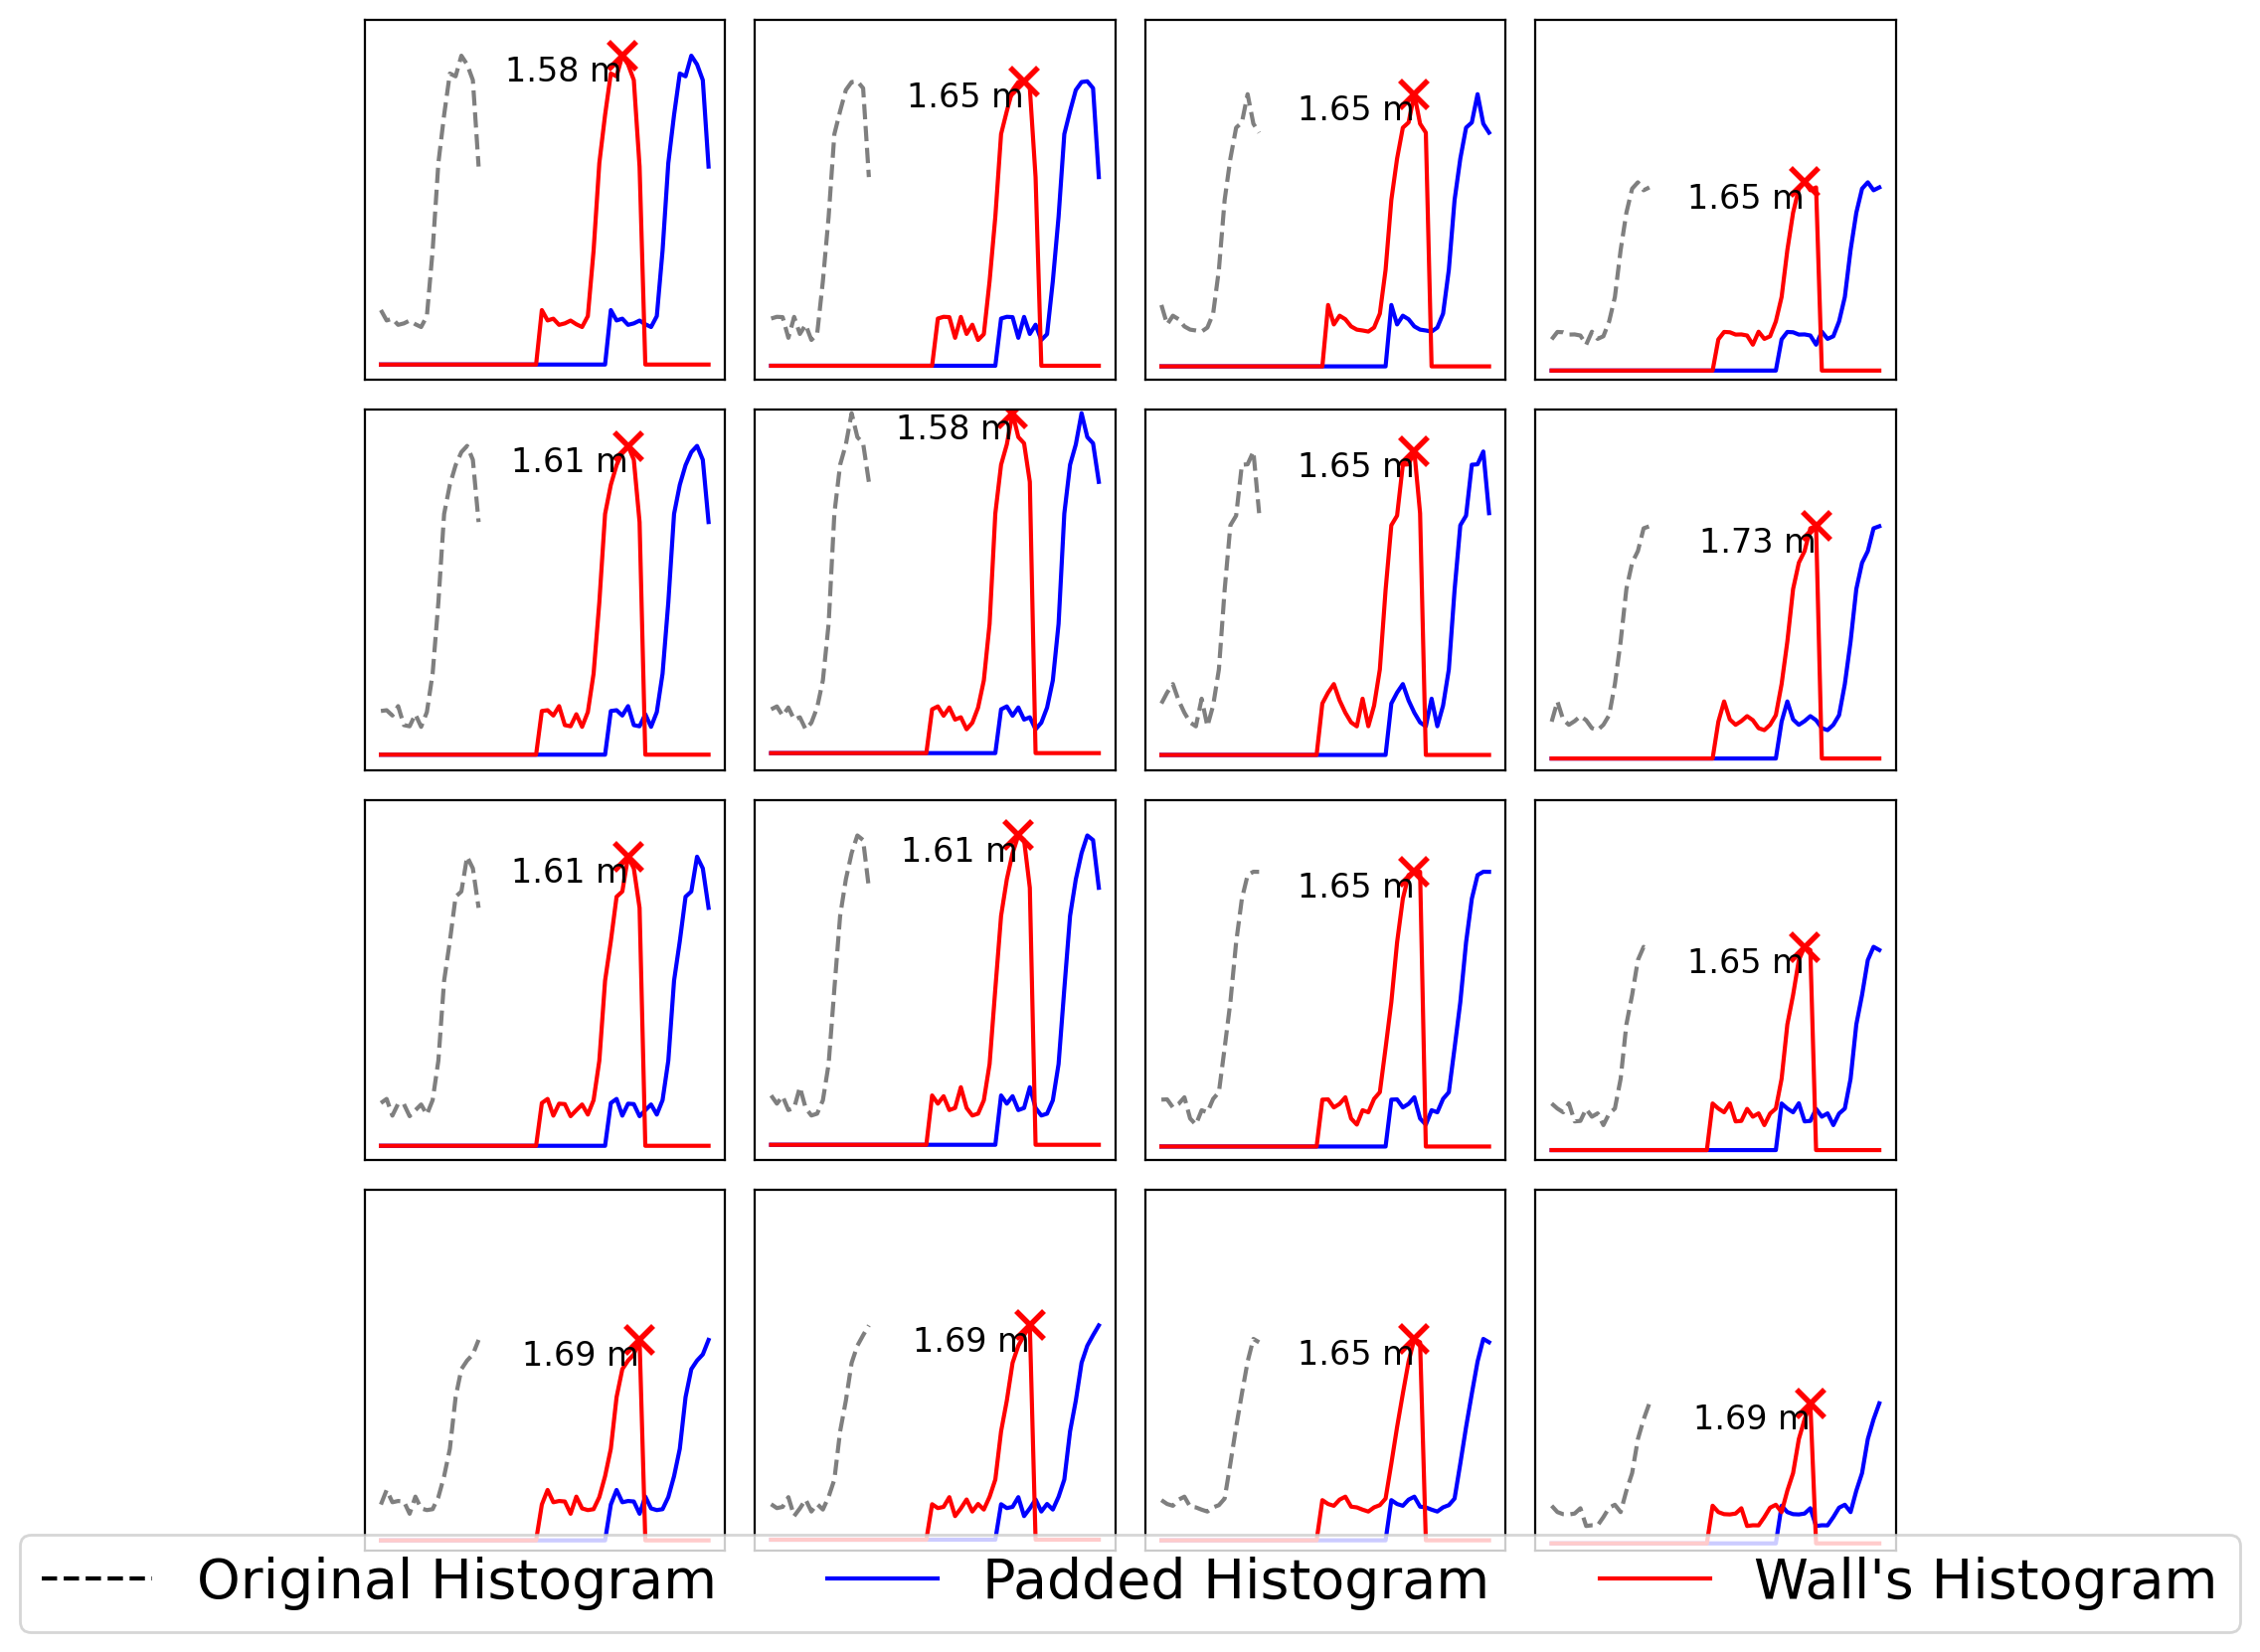

(0.0, 1.9383513879169911)

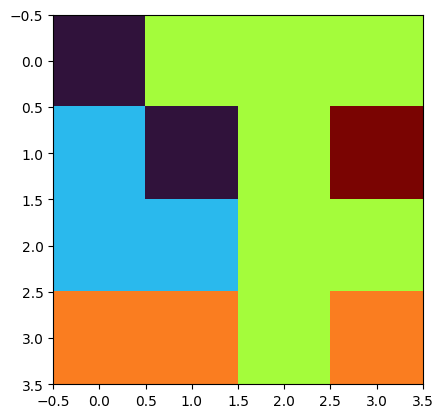

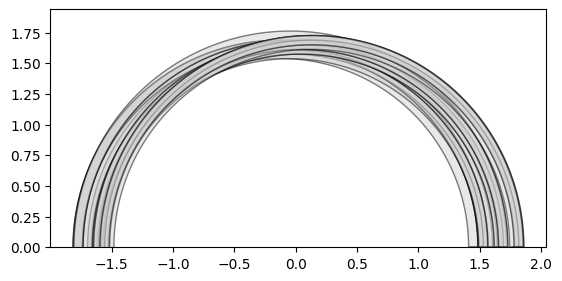

In [61]:
def extend_histograms(data, sensor_config, return_bins=False):
    assert SPADDataType.HISTOGRAM in data, "Histogram missing"
    histograms = data[SPADDataType.HISTOGRAM]
    start_bin = sensor_config.start_bin
    num_bins = sensor_config.num_bins
    subsample = sensor_config.subsample
    extended_bins = np.arange(0, start_bin + num_bins * subsample, subsample)
    extended_histograms = np.zeros(histograms.shape[:-1] + (len(extended_bins),))
    for i in range(histograms.shape[0]):
        for j in range(histograms.shape[1]):
            extended_histograms[i, j, -histograms.shape[2]:] = histograms[i, j]
    if return_bins:
        return extended_bins, extended_histograms
    return extended_histograms

def process_histograms(data, sensor_config):
    assert SPADDataType.HISTOGRAM in data, "Histogram missing"
    assert SPADDataType.DISTANCE in data, "Distance missing"
    histograms = data[SPADDataType.HISTOGRAM]
    distances = data[SPADDataType.DISTANCE]
    extended_bins, extended_histograms = extend_histograms(data, sensor_config, return_bins=True)
    processed_histograms = np.zeros_like(extended_histograms)
    for i in range(histograms.shape[0]):
        for j in range(histograms.shape[1]):
            distance = distances[i, j]
            distance_bin = distance / 1000 * 2 / C / sensor_config.timing_resolution
            closest_bin = np.argmin(np.abs(extended_bins - distance_bin))
            subsample = sensor_config.subsample
            adjusted_bins = (extended_bins - closest_bin * subsample)[closest_bin:]
            adjusted_hist = extended_histograms[i, j, closest_bin:]
            processed_histograms[i, j, :len(adjusted_hist)] = adjusted_hist
    return processed_histograms

def align_plane(pt_cloud: np.ndarray, dist_threshold=0.01) -> np.ndarray:
    pts = pt_cloud.reshape(-1, 3)
    centroid = pts.mean(axis=0)
    _, _, vh = np.linalg.svd(pts - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    dists = np.dot(pts - centroid, normal)
    inliers = pts[np.abs(dists) < dist_threshold]
    centroid = inliers.mean(axis=0)
    _, _, vh = np.linalg.svd(inliers - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    target = np.array([0, 0, 1.0])
    axis = np.cross(normal, target)
    if np.linalg.norm(axis) < 1e-6:
        R = np.eye(3)
    else:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(normal, target))
        K = np.array([[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)
    pts_trans = (pts - centroid) @ R.T
    mask = np.abs(pts_trans @ target) < dist_threshold
    plane_z = pts_trans[mask, 2].mean()
    pts_trans[:, 2] -= plane_z
    return pts_trans.reshape(pt_cloud.shape)

data = sensor.accumulate(index=index)


datas = []
for i in range(4, len(sensor.handler)):
    data = sensor.accumulate(index=i)
    datas.append(data)
# data = {
#     SPADDataType.HISTOGRAM: np.mean([d[SPADDataType.HISTOGRAM] for d in datas], axis=0) - background_data[SPADDataType.HISTOGRAM],
#     SPADDataType.DISTANCE: np.mean([d[SPADDataType.DISTANCE] for d in datas], axis=0),
#     SPADDataType.POINT_CLOUD: np.mean([d[SPADDataType.POINT_CLOUD] for d in datas], axis=0),
# }
# data = sensor.accumulate(index=index)
histograms = data[SPADDataType.HISTOGRAM]
extended_histograms = extend_histograms(data, sensor_config)
processed_histograms = process_histograms(data, sensor_config)

ylim = histograms.max() * 1.01
min_bin = 0
max_bin = min(histograms.shape[-1] - 1, 60)

distances = []
def plot_histogram(i: int, j: int):
    plt.subplot(height, width, i * height + j + 1)
    
    plt.plot(histograms[i, j], '--k', alpha=0.5)
    plt.plot(extended_histograms[i, j], '-b')
    plt.plot(processed_histograms[i, j], '-r')
    # plt.title(f"i={i}, j={j}")
    # plt.yscale("log")

    # peak_bin = np.argmax(processed_histograms[i, j])
    peaks, _ = find_peaks(processed_histograms[i, j])
    peak_bin = peaks[np.argmax(peaks)]
    peak_bin = peaks[np.argmax(processed_histograms[i, j][peaks])]
    peak_distance = peak_bin * sensor_config.timing_resolution * sensor_config.subsample * C / 2
    plt.plot(peak_bin, processed_histograms[i, j, peak_bin], 'rx', markersize=10, label="Peak", markeredgewidth=2)
    plt.text(peak_bin, processed_histograms[i, j, peak_bin], f"{peak_distance:.2f} m", fontsize=12, ha='right', va='top')
    distances.append(peak_distance)

    plt.xlabel("")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("")

    if ylim is not None:
        plt.ylim(None, ylim)
    # if min_bin is not None:
    #     plt.xlim(min_bin, None)
    # if max_bin is not None:
    #     plt.xlim(None, max_bin)

fig = plt.figure(figsize=(height * 2, width * 2), dpi=200)
for i in range(height):
    for j in range(width):
        plot_histogram(i, j)

# legend
legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='--', label='Original Histogram'),
    plt.Line2D([0], [0], color='b', label='Padded Histogram'),
    plt.Line2D([0], [0], color='r', label='Wall\'s Histogram'),
]
# plt.legend(handles=legend_elements)
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to leave space for legend
plt.subplots_adjust(bottom=0.1)  # Adjust as needed to make space
plt.tight_layout()
plt.show()

plt.figure()
distances = np.array(distances).reshape(height, width)
plt.imshow(distances, cmap='turbo')

plt.figure()
plt.gca().set_aspect('equal', adjustable='box')
point_cloud = data[SPADDataType.POINT_CLOUD]
point_cloud = align_plane(point_cloud).reshape(height, width, 3)

def plot_circular_shell(center, inner_radius, outer_radius, num_points=500):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x_inner = center[0] + inner_radius * np.cos(theta)
    y_inner = center[1] + inner_radius * np.sin(theta)
    x_outer = center[0] + outer_radius * np.cos(theta)
    y_outer = center[1] + outer_radius * np.sin(theta)

    x = np.concatenate([x_outer, x_inner[::-1]])
    y = np.concatenate([y_outer, y_inner[::-1]])

    plt.fill(x, y, color='lightgray', alpha=0.5, edgecolor='black')

# plt.plot(point_cloud[:, 0], point_cloud[:, 1], 'b.', markersize=10)

for i in range(height):
    for j in range(width):
        radius_inner = distances[i, j] - sensor_config.timing_resolution * sensor_config.subsample * C / 2
        radius_outer = distances[i, j] + sensor_config.timing_resolution * sensor_config.subsample * C / 2
        plot_circular_shell((point_cloud[i, j, 0], point_cloud[i, j, 2]), radius_inner, radius_outer)
plt.ylim(0, None)

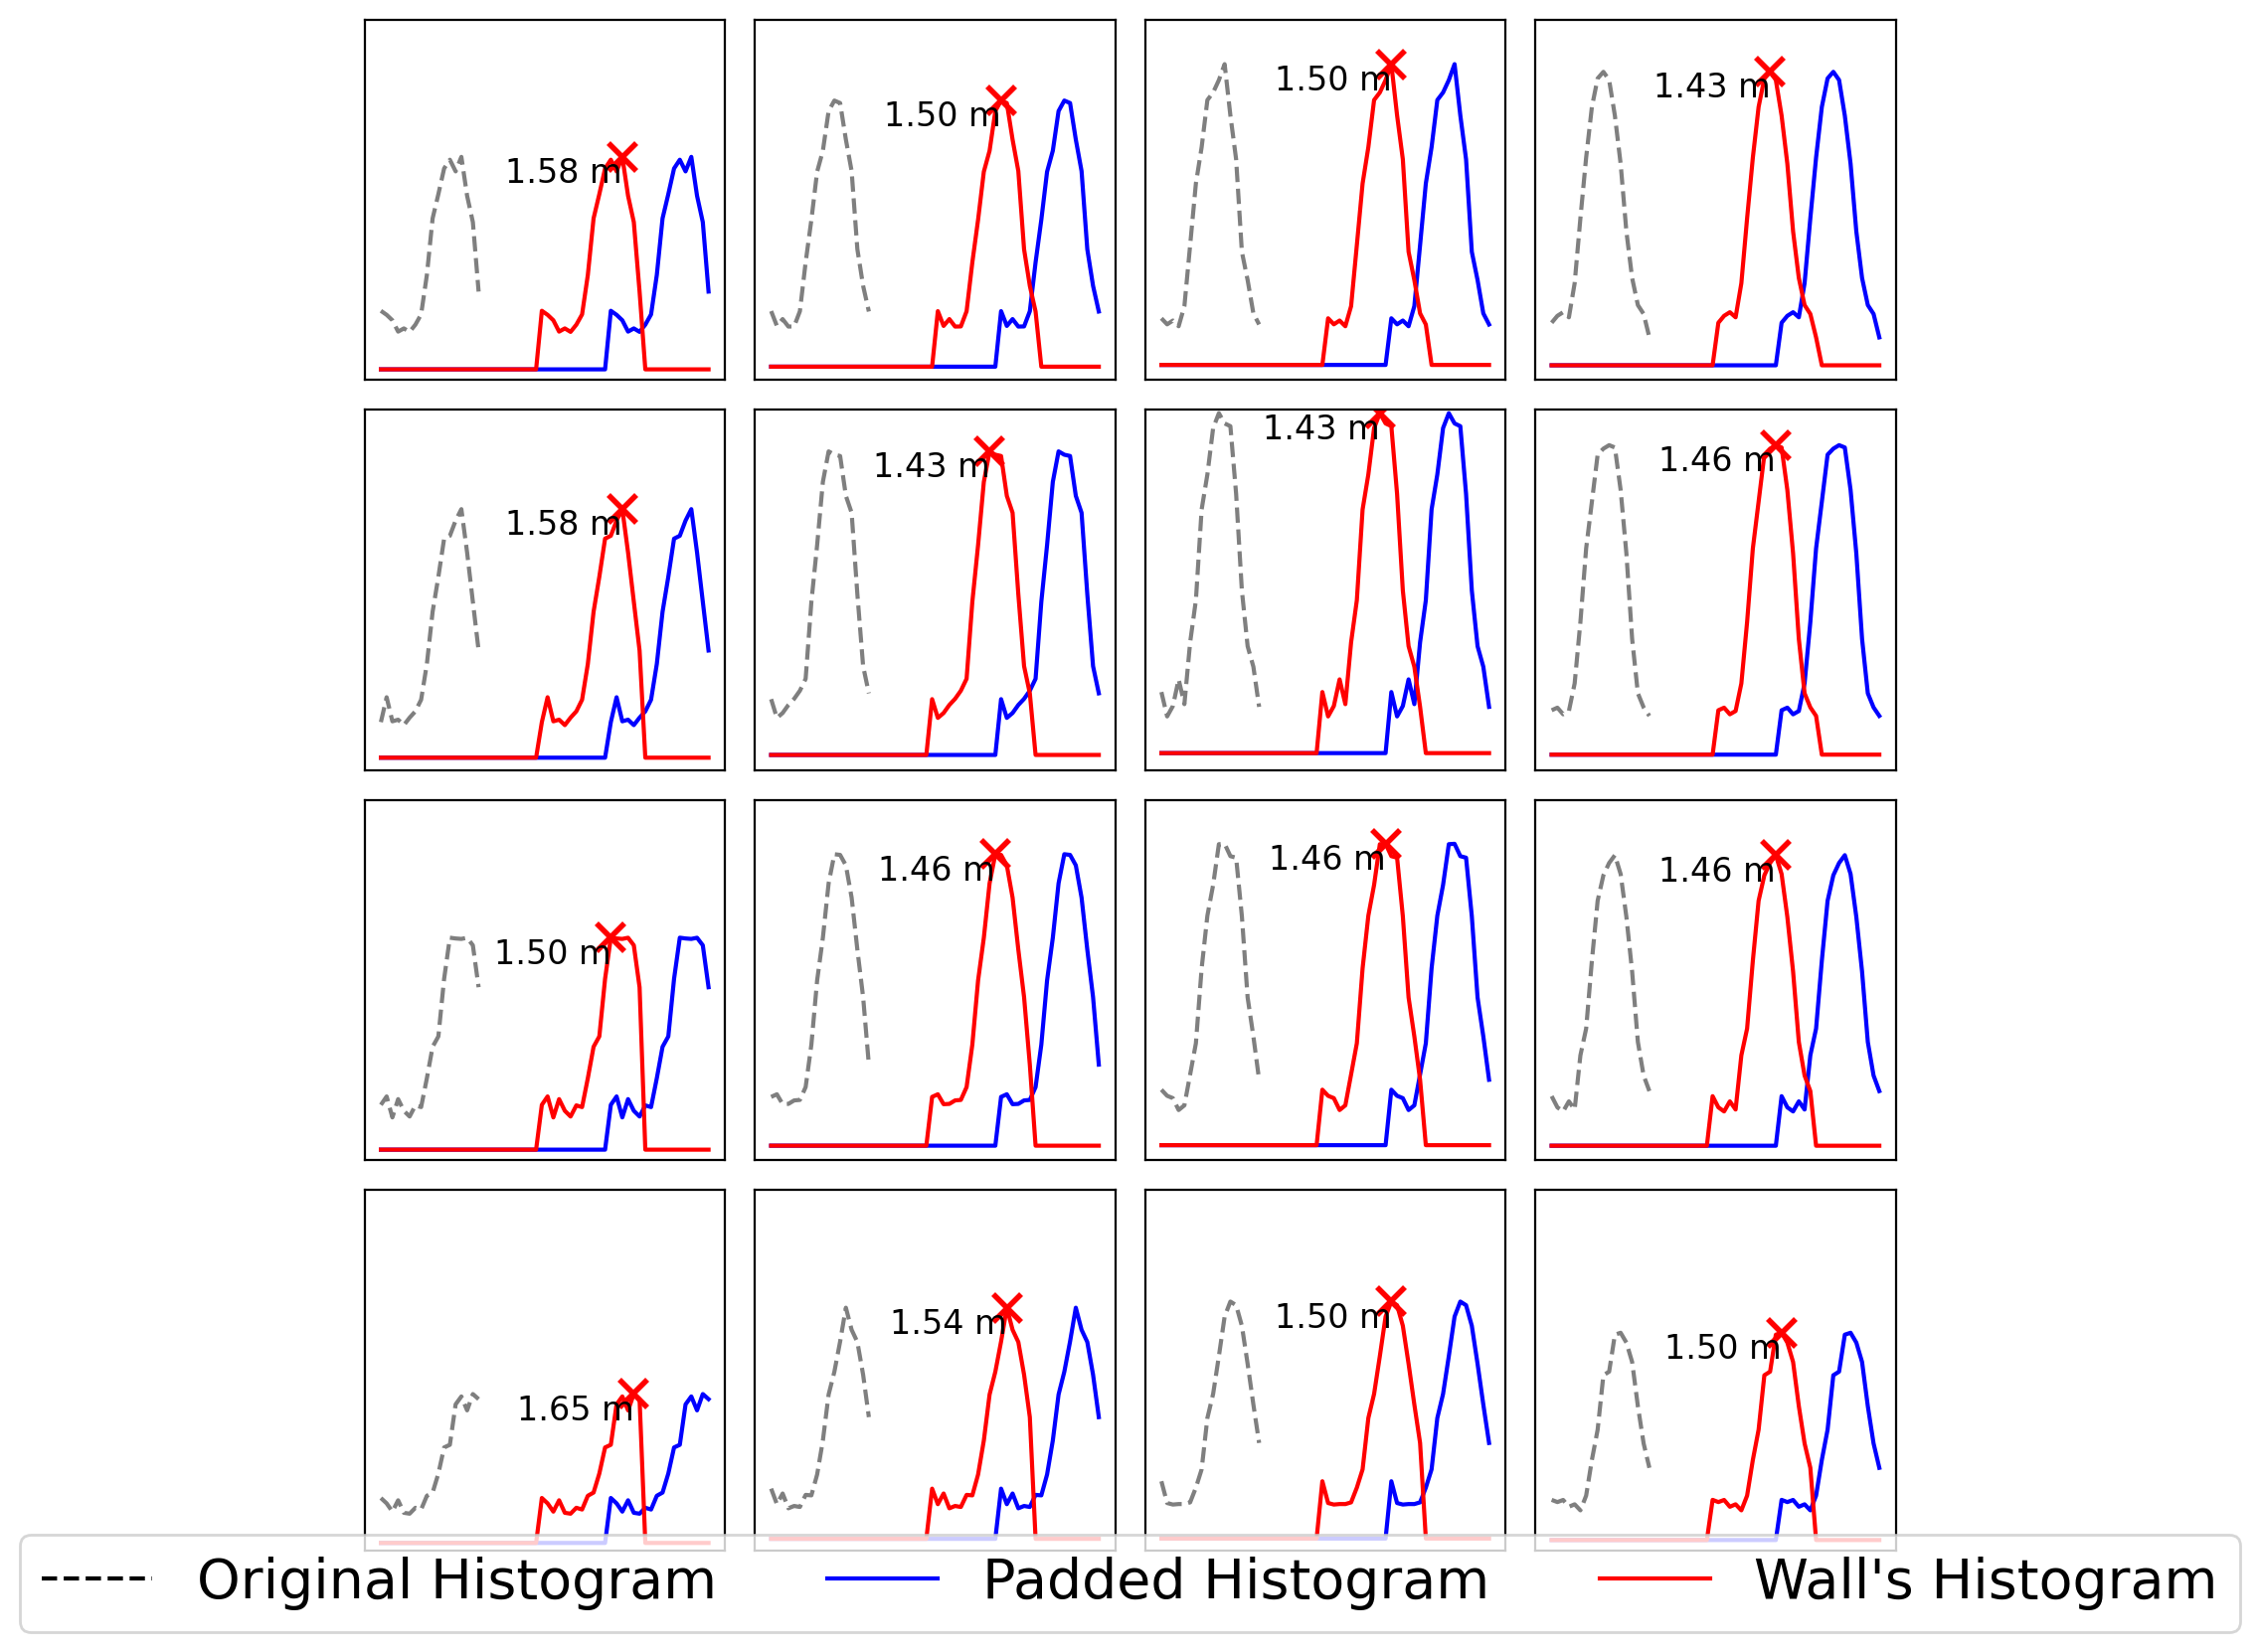

(0.0, 1.8569468304583783)

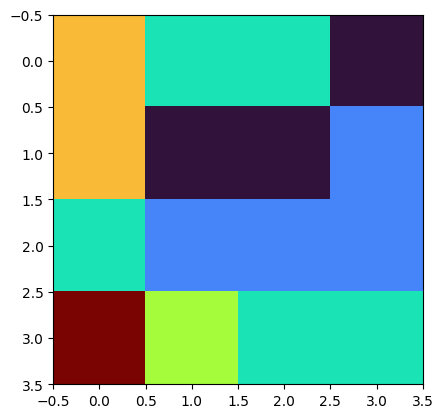

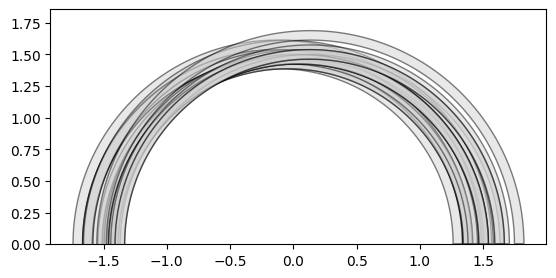

In [63]:
def extend_histograms(data, sensor_config, return_bins=False):
    assert SPADDataType.HISTOGRAM in data, "Histogram missing"
    histograms = data[SPADDataType.HISTOGRAM]
    start_bin = sensor_config.start_bin
    num_bins = sensor_config.num_bins
    subsample = sensor_config.subsample
    extended_bins = np.arange(0, start_bin + num_bins * subsample, subsample)
    extended_histograms = np.zeros(histograms.shape[:-1] + (len(extended_bins),))
    for i in range(histograms.shape[0]):
        for j in range(histograms.shape[1]):
            extended_histograms[i, j, -histograms.shape[2]:] = histograms[i, j]
    if return_bins:
        return extended_bins, extended_histograms
    return extended_histograms

def process_histograms(data, sensor_config):
    assert SPADDataType.HISTOGRAM in data, "Histogram missing"
    assert SPADDataType.DISTANCE in data, "Distance missing"
    histograms = data[SPADDataType.HISTOGRAM]
    distances = data[SPADDataType.DISTANCE]
    extended_bins, extended_histograms = extend_histograms(data, sensor_config, return_bins=True)
    processed_histograms = np.zeros_like(extended_histograms)
    for i in range(histograms.shape[0]):
        for j in range(histograms.shape[1]):
            distance = distances[i, j]
            distance_bin = distance / 1000 * 2 / C / sensor_config.timing_resolution
            closest_bin = np.argmin(np.abs(extended_bins - distance_bin))
            subsample = sensor_config.subsample
            adjusted_bins = (extended_bins - closest_bin * subsample)[closest_bin:]
            adjusted_hist = extended_histograms[i, j, closest_bin:]
            processed_histograms[i, j, :len(adjusted_hist)] = adjusted_hist
    return processed_histograms

def align_plane(pt_cloud: np.ndarray, dist_threshold=0.01) -> np.ndarray:
    pts = pt_cloud.reshape(-1, 3)
    centroid = pts.mean(axis=0)
    _, _, vh = np.linalg.svd(pts - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    dists = np.dot(pts - centroid, normal)
    inliers = pts[np.abs(dists) < dist_threshold]
    centroid = inliers.mean(axis=0)
    _, _, vh = np.linalg.svd(inliers - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    target = np.array([0, 0, 1.0])
    axis = np.cross(normal, target)
    if np.linalg.norm(axis) < 1e-6:
        R = np.eye(3)
    else:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(normal, target))
        K = np.array([[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)
    pts_trans = (pts - centroid) @ R.T
    mask = np.abs(pts_trans @ target) < dist_threshold
    plane_z = pts_trans[mask, 2].mean()
    pts_trans[:, 2] -= plane_z
    return pts_trans.reshape(pt_cloud.shape)

data = sensor.accumulate(index=index)


datas = []
for i in range(4, len(sensor.handler)):
    data = sensor.accumulate(index=i)
    datas.append(data)
# data = {
#     SPADDataType.HISTOGRAM: np.mean([d[SPADDataType.HISTOGRAM] for d in datas], axis=0) - background_data[SPADDataType.HISTOGRAM],
#     SPADDataType.DISTANCE: np.mean([d[SPADDataType.DISTANCE] for d in datas], axis=0),
#     SPADDataType.POINT_CLOUD: np.mean([d[SPADDataType.POINT_CLOUD] for d in datas], axis=0),
# }
# data = sensor.accumulate(index=index)
histograms = data[SPADDataType.HISTOGRAM]
extended_histograms = extend_histograms(data, sensor_config)
processed_histograms = process_histograms(data, sensor_config)

ylim = histograms.max() * 1.01
min_bin = 0
max_bin = min(histograms.shape[-1] - 1, 60)

distances = []
def plot_histogram(i: int, j: int):
    plt.subplot(height, width, i * height + j + 1)
    
    plt.plot(histograms[i, j], '--k', alpha=0.5)
    plt.plot(extended_histograms[i, j], '-b')
    plt.plot(processed_histograms[i, j], '-r')
    # plt.title(f"i={i}, j={j}")
    # plt.yscale("log")

    # peak_bin = np.argmax(processed_histograms[i, j])
    peaks, _ = find_peaks(processed_histograms[i, j])
    peak_bin = peaks[np.argmax(peaks)]
    peak_bin = peaks[np.argmax(processed_histograms[i, j][peaks])]
    peak_distance = peak_bin * sensor_config.timing_resolution * sensor_config.subsample * C / 2
    plt.plot(peak_bin, processed_histograms[i, j, peak_bin], 'rx', markersize=10, label="Peak", markeredgewidth=2)
    plt.text(peak_bin, processed_histograms[i, j, peak_bin], f"{peak_distance:.2f} m", fontsize=12, ha='right', va='top')
    distances.append(peak_distance)

    # set title of subplot
    # plt.title(f"{i},{j}, bin={peak_bin}, dist={peak_distance:.2f} m", fontsize=10)
    plt.xlabel("")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("")

    if ylim is not None:
        plt.ylim(None, ylim)
    # if min_bin is not None:
    #     plt.xlim(min_bin, None)
    # if max_bin is not None:
    #     plt.xlim(None, max_bin)

fig = plt.figure(figsize=(height * 2, width * 2), dpi=200)
for i in range(height):
    for j in range(width):
        plot_histogram(i, j)

# legend
legend_elements = [
    plt.Line2D([0], [0], color='k', linestyle='--', label='Original Histogram'),
    plt.Line2D([0], [0], color='b', label='Padded Histogram'),
    plt.Line2D([0], [0], color='r', label='Wall\'s Histogram'),
]
# plt.legend(handles=legend_elements)
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to leave space for legend
plt.subplots_adjust(bottom=0.1)  # Adjust as needed to make space
plt.tight_layout()
plt.show()

plt.figure()
distances = np.array(distances).reshape(height, width)
plt.imshow(distances, cmap='turbo')

plt.figure()
plt.gca().set_aspect('equal', adjustable='box')
point_cloud = data[SPADDataType.POINT_CLOUD]
point_cloud = align_plane(point_cloud).reshape(height, width, 3)

def plot_circular_shell(center, inner_radius, outer_radius, num_points=500):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x_inner = center[0] + inner_radius * np.cos(theta)
    y_inner = center[1] + inner_radius * np.sin(theta)
    x_outer = center[0] + outer_radius * np.cos(theta)
    y_outer = center[1] + outer_radius * np.sin(theta)

    x = np.concatenate([x_outer, x_inner[::-1]])
    y = np.concatenate([y_outer, y_inner[::-1]])

    plt.fill(x, y, color='lightgray', alpha=0.5, edgecolor='black')

# plt.plot(point_cloud[:, 0], point_cloud[:, 1], 'b.', markersize=10)

for i in range(height):
    for j in range(width):
        radius_inner = distances[i, j] - sensor_config.timing_resolution * sensor_config.subsample * C / 2
        radius_outer = distances[i, j] + sensor_config.timing_resolution * sensor_config.subsample * C / 2
        plot_circular_shell((point_cloud[i, j, 0], point_cloud[i, j, 2]), radius_inner, radius_outer)
plt.ylim(0, None)

Text(0, 0.5, 'Y (m)')

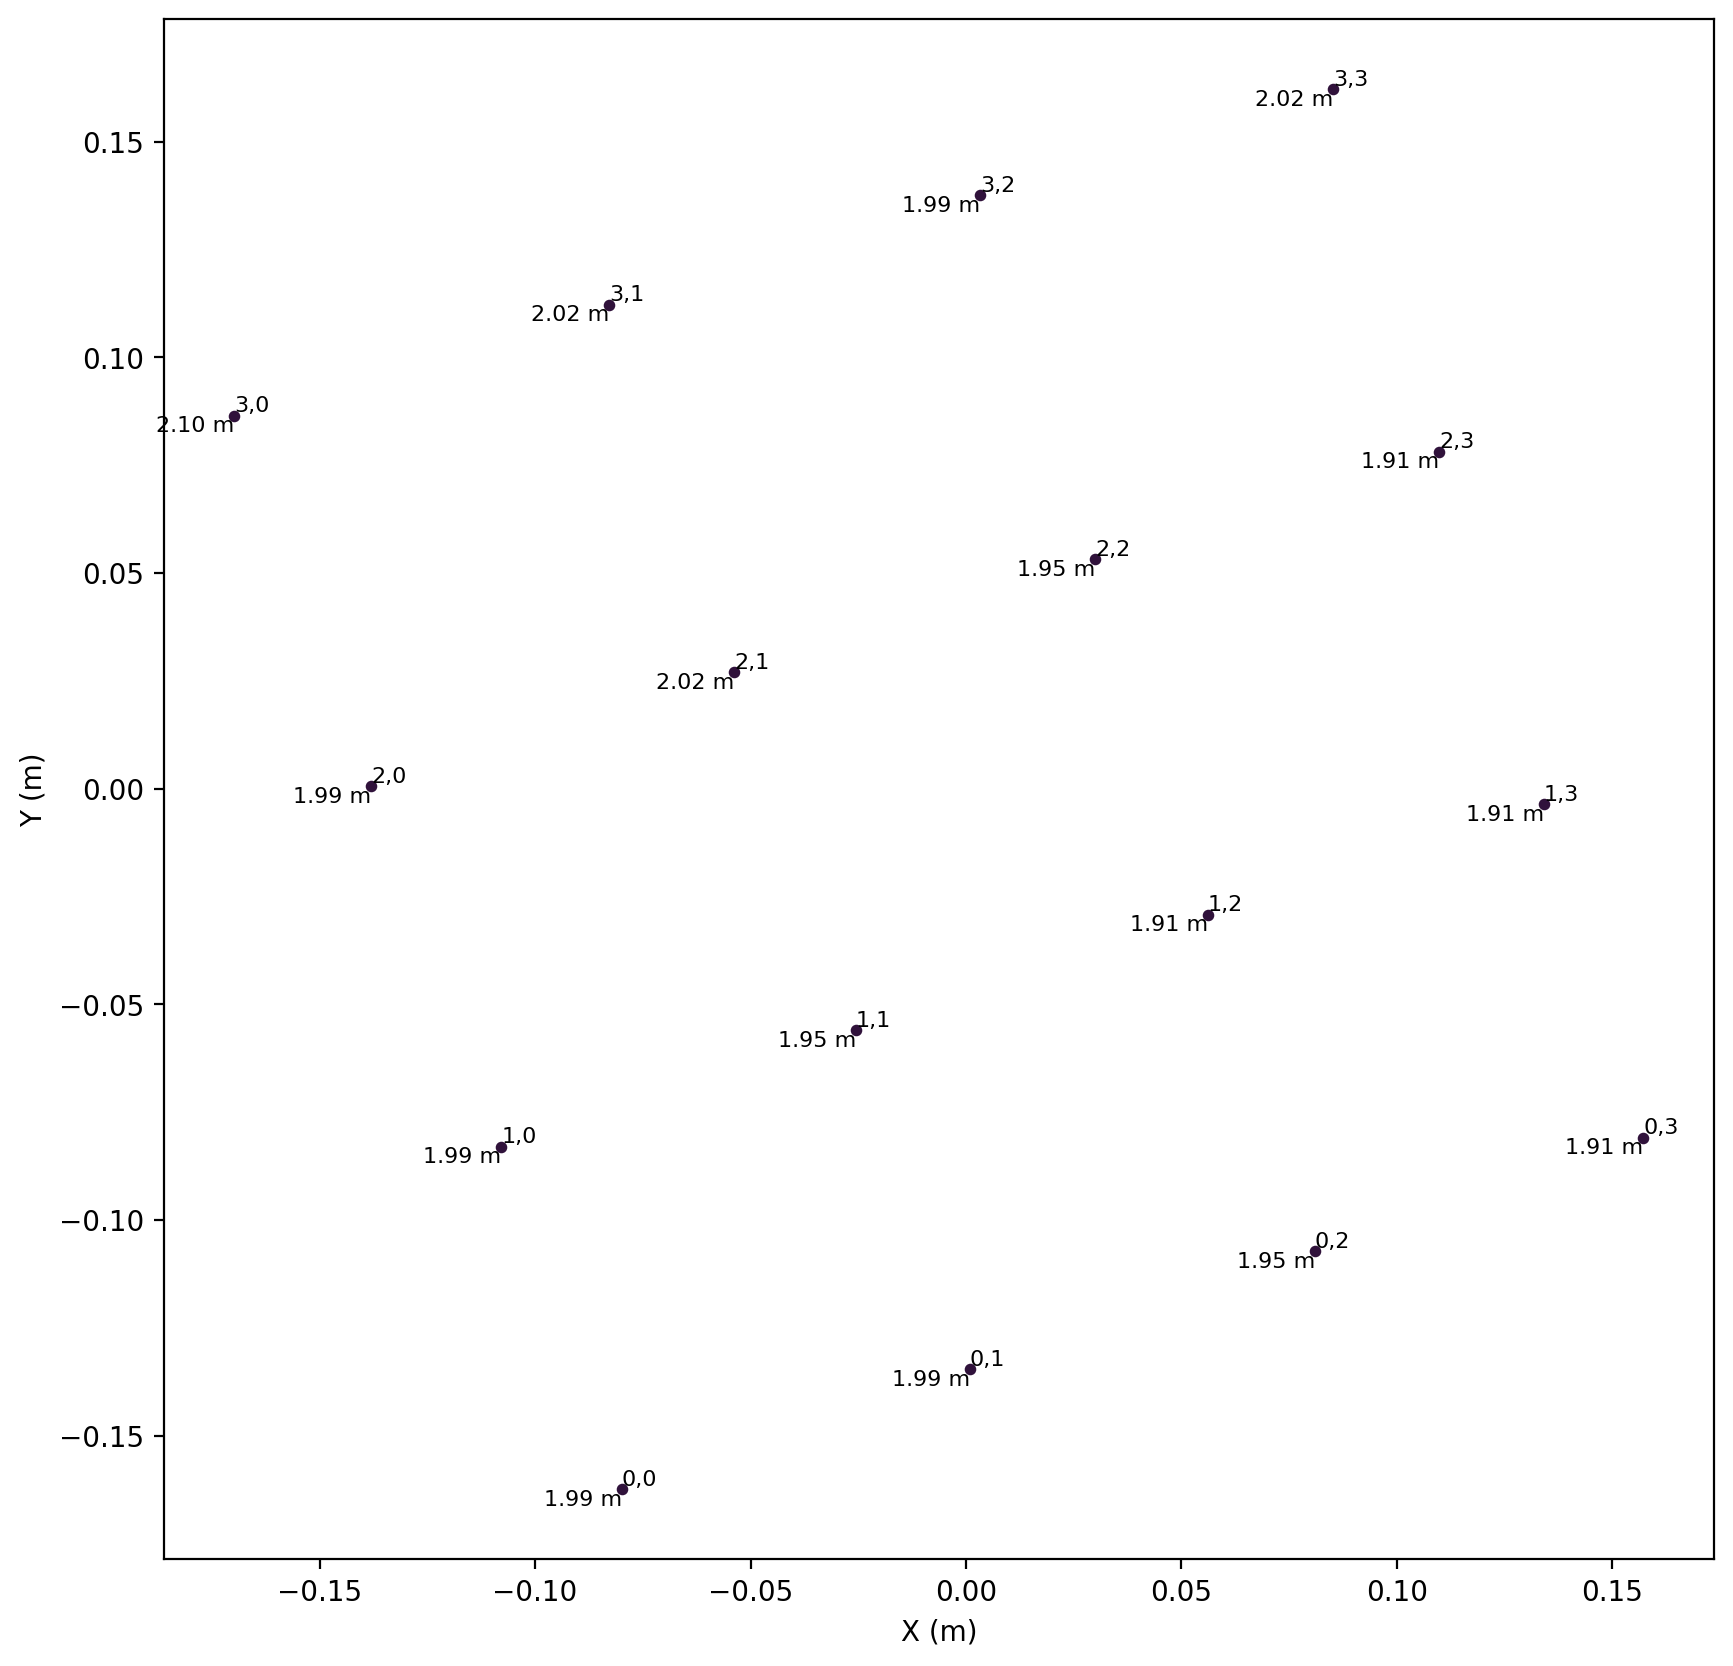

In [14]:
def align_plane(pt_cloud: np.ndarray, dist_threshold=0.01) -> np.ndarray:
    pts = pt_cloud.reshape(-1, 3)
    centroid = pts.mean(axis=0)
    _, _, vh = np.linalg.svd(pts - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    dists = np.dot(pts - centroid, normal)
    inliers = pts[np.abs(dists) < dist_threshold]
    centroid = inliers.mean(axis=0)
    _, _, vh = np.linalg.svd(inliers - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    target = np.array([0, 0, 1.0])
    axis = np.cross(normal, target)
    if np.linalg.norm(axis) < 1e-6:
        R = np.eye(3)
    else:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(normal, target))
        K = np.array([[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)
    pts_trans = (pts - centroid) @ R.T
    mask = np.abs(pts_trans @ target) < dist_threshold
    plane_z = pts_trans[mask, 2].mean()
    pts_trans[:, 2] -= plane_z
    return pts_trans.reshape(pt_cloud.shape)

data = sensor.accumulate(index=index)

pt_cloud = data[SPADDataType.POINT_CLOUD].copy()
aligned_pt_cloud = align_plane(pt_cloud).reshape(height, width, 3)
pt_cloud = pt_cloud.reshape(height, width, 3)

histograms = data[SPADDataType.HISTOGRAM]
extended_histograms = extend_histograms(data, sensor_config).reshape(height, width, -1)

# plt.scatter(aligned_pt_cloud[:, 0], aligned_pt_cloud[:, 1], c=pt_cloud[:, 2], cmap='turbo', s=10)
plt.figure(figsize=(10, 10), dpi=200)
for i in range(height):
    for j in range(width):
        plt.scatter(aligned_pt_cloud[i, j, 0], aligned_pt_cloud[i, j, 1], c=pt_cloud[i, j, 2], cmap='turbo', s=10)
        plt.text(aligned_pt_cloud[i, j, 0], aligned_pt_cloud[i, j, 1], f"{i},{j}", fontsize=8, ha='left', va='bottom')

        # Find peak of histogram
        peak_bin = np.argmax(extended_histograms[i, j])
        peak_distance = peak_bin * sensor_config.timing_resolution * sensor_config.subsample / 2 * C
        plt.text(aligned_pt_cloud[i, j, 0], aligned_pt_cloud[i, j, 1], f"{peak_distance:.2f} m", fontsize=8, ha='right', va='top')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

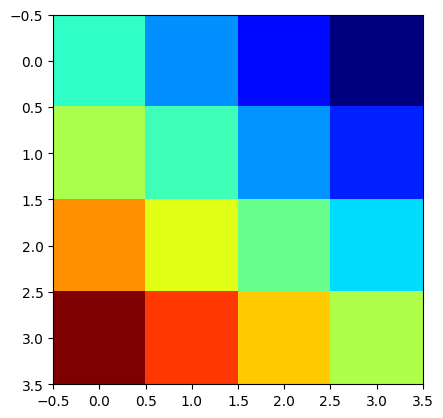

In [15]:
sensor_data = SPADSensorData(sensor.config)
sensor_data.process(sensor.accumulate(index=index))

data = sensor_data.get_data()
distance = data[SPADDataType.DISTANCE]

plt.imshow(
    distance,
    cmap="jet",
)

In [16]:
sensor_data = SPADSensorData(sensor.config)
sensor_data.process(sensor.accumulate(index=index))

data = sensor_data.get_data()

# distances = data[SPADDataType.DISTANCE]
# pt_cloud = sensor_data.calculate_point_cloud(distances=distances, subpixel_samples=5, bilinear_interpolation=True)

pt_cloud = data[SPADDataType.POINT_CLOUD]

# Flatten the point cloud for Plotly
x = pt_cloud[..., 0].flatten()
y = pt_cloud[..., 1].flatten()
z = pt_cloud[..., 2].flatten()

fig = go.Figure(data=
    [
        go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color='blue', size=3)),
    ]
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'  # or 'cube' or 'manual' with 'aspectratio'
    )
)

fig.show()

In [17]:
import numpy as np

# assemble points
pts = np.vstack((x, y, z)).T

# initial plane fit
centroid = pts.mean(axis=0)
_, _, vh = np.linalg.svd(pts - centroid)
normal = vh[2]

# filter outliers
dist_threshold = 0.01  # adjust as needed
dists = np.dot(pts - centroid, normal)
inliers = pts[np.abs(dists) < dist_threshold]

# refit plane to inliers
centroid = inliers.mean(axis=0)
_, _, vh = np.linalg.svd(inliers - centroid)
e1, e2 = vh[0], vh[1]

# create plane grid
d = np.max(np.ptp(inliers, axis=0))
u = np.linspace(-d/2, d/2, 10)
v = np.linspace(-d/2, d/2, 10)
uu, vv = np.meshgrid(u, v)
plane_pts = centroid + uu[..., None]*e1 + vv[..., None]*e2
px, py, pz = plane_pts[...,0], plane_pts[...,1], plane_pts[...,2]

# add to figure
fig = go.Figure(data=(
    go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color='blue', size=3)),
))
fig.add_trace(go.Surface(x=px, y=py, z=pz, showscale=False, opacity=0.5))
fig.show()


In [18]:
import numpy as np

# compute centroid & normal as before
pts = np.vstack((x, y, z)).T
centroid = inliers.mean(axis=0)
_, _, vh = np.linalg.svd(inliers - centroid)
normal = vh[2] / np.linalg.norm(vh[2])

# build rotation matrix to align normal with Z
target = np.array([0, 0, 1.0])
axis = np.cross(normal, target)
if np.linalg.norm(axis) < 1e-6:
    R = np.eye(3)
else:
    axis = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(normal, target))
    K = np.array([
        [    0, -axis[2],  axis[1]],
        [ axis[2],     0, -axis[0]],
        [-axis[1],  axis[0],     0]
    ])
    R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)

# apply to whole cloud
pts_trans = (pts - centroid) @ R.T

# shift so inliers lie exactly at z=0
mask = np.abs((pts_trans @ target)) < dist_threshold
pts_trans[:, 2] -= pts_trans[mask, 2].mean()

# unpack and plot
x2, y2, z2 = pts_trans.T
fig = go.Figure(go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', marker=dict(color='blue', size=3)))
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'))
fig.show()


In [64]:
def backproject(
    voxel_grid: np.ndarray,
    pt_clouds: np.ndarray,
    hists: np.ndarray,
    bin_width: float,
) -> np.ndarray:
    C = 3E8
    thresh = bin_width * C
    factor = bin_width * C / 2
    num_bins = hists.shape[1]

    # Precompute cumulative histograms for all rows to avoid redundant computation.
    cum_hists = np.cumsum(hists, axis=1)

    volume = np.zeros((len(voxel_grid), 1))
    for i, cur_pixel in enumerate(pt_clouds):
        # Compute voxel distances for the current pixel.
        dists = np.linalg.norm(voxel_grid - cur_pixel, axis=1)
        # Retrieve the precomputed cumulative histogram for this pixel.
        cum = cum_hists[i, :]

        # Determine the lower and upper bin indices for each voxel.
        lower = np.clip(
            np.ceil((dists - thresh) / factor).astype(int), 0, num_bins - 1
        )
        upper = np.clip(
            np.floor((dists + thresh) / factor).astype(int), 0, num_bins - 1
        )

        # Compute the range sum using the cumulative histogram.
        sums = cum[upper] - np.where(lower > 0, cum[lower - 1], 0)
        volume += sums.reshape(-1, 1)

    return volume

def filter_volume(volume: np.ndarray, num_x, num_y) -> np.ndarray:
    volume_unpadded = 2 * volume[:, :, 1:-1] - volume[:, :, :-2] - volume[:, :, 2:]
    zero_pad = np.zeros((num_x, num_y, 1))
    volume_padded = np.concatenate([zero_pad, volume_unpadded, zero_pad], axis=-1)
    return volume_padded

def align_plane(pt_cloud: np.ndarray, dist_threshold=0.01) -> np.ndarray:
    pts = pt_cloud.reshape(-1, 3)
    centroid = pts.mean(axis=0)
    _, _, vh = np.linalg.svd(pts - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    dists = np.dot(pts - centroid, normal)
    inliers = pts[np.abs(dists) < dist_threshold]
    centroid = inliers.mean(axis=0)
    _, _, vh = np.linalg.svd(inliers - centroid)
    normal = vh[2] / np.linalg.norm(vh[2])
    target = np.array([0, 0, 1.0])
    axis = np.cross(normal, target)
    if np.linalg.norm(axis) < 1e-6:
        R = np.eye(3)
    else:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(normal, target))
        K = np.array([[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1 - np.cos(angle))*(K @ K)
    pts_trans = (pts - centroid) @ R.T
    mask = np.abs(pts_trans @ target) < dist_threshold
    plane_z = pts_trans[mask, 2].mean()
    pts_trans[:, 2] -= plane_z
    return pts_trans.reshape(pt_cloud.shape)

def create_voxel_grid(x_range, y_range, z_range, x_res=None, y_res=None, z_res=None, num_x=None, num_y=None, num_z=None):
    if x_res is not None and y_res is not None and z_res is not None:
        num_x = int((x_range[1] - x_range[0]) / x_res)
        num_y = int((y_range[1] - y_range[0]) / y_res)
        num_z = int((z_range[1] - z_range[0]) / z_res)
    elif num_x is not None and num_y is not None and num_z is not None:
        x_res = (x_range[1] - x_range[0]) / num_x
        y_res = (y_range[1] - y_range[0]) / num_y
        z_res = (z_range[1] - z_range[0]) / num_z
    else:
        raise ValueError("Either resolutions (x_res, y_res, z_res) or numbers (num_x, num_y, num_z) must be provided.")

    x = np.linspace(x_range[0], x_range[1], num_x, endpoint=False)
    y = np.linspace(y_range[0], y_range[1], num_y, endpoint=False)
    z = np.linspace(z_range[0], z_range[1], num_z, endpoint=False)
    xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
    voxel_grid = np.stack([xv.ravel(), yv.ravel(), zv.ravel()], axis=-1)
    return voxel_grid, num_x, num_y, num_z, x_res, y_res, z_res

x_range = [-1, 1]
y_range = [-1, 1]
z_range = [0, 2]
num_x = 50
num_y = 50
num_z = 25
voxel_grid, num_x, num_y, num_z, x_res, y_res, z_res = create_voxel_grid(
    x_range=x_range,
    y_range=y_range,
    z_range=z_range,
    num_x=num_x,
    num_y=num_y,
    num_z=num_z,
)

background_histogram = process_histograms(background_data, background_sensor_config).reshape(background_sensor_config.height * background_sensor_config.width, -1)

histograms, pt_clouds = [], []
for i in range(1, len(sensor.handler)):
    sensor_data = SPADSensorData(sensor.config)
    sensor_data.process(sensor.accumulate(index=i))

    data = sensor_data.get_data()
    assert SPADDataType.HISTOGRAM in data
    assert SPADDataType.POINT_CLOUD in data
    assert SPADDataType.DISTANCE in data
    
    distance = data[SPADDataType.DISTANCE].reshape(-1, 1).copy()
    histogram = data[SPADDataType.HISTOGRAM].reshape(-1, sensor.config.num_bins).copy()
    pt_cloud = data[SPADDataType.POINT_CLOUD].reshape(-1, 3).copy()

    pt_cloud = align_plane(pt_cloud)
    pt_cloud[..., [0]] *= -1

    # histogram = extend_histograms(data, sensor_config).reshape(sensor.config.height * sensor.config.width, -1)
    histogram = process_histograms(data, sensor_config).reshape(sensor.config.height * sensor.config.width, -1)
    # if histogram.shape[1] > background_histogram.shape[1]:
    #     # Pad the background histogram to match the shape of the current histogram
    #     background_histogram = np.pad(background_histogram, ((0, 0), (0, histogram.shape[1] - background_histogram.shape[1])), mode='constant')
    # histogram -= background_histogram

    histograms.append(histogram)
    pt_clouds.append(pt_cloud)
hists_to_use = np.array(histograms).copy()[2:]
pt_clouds_to_use = np.array(pt_clouds).copy()[2:]

# hists_to_use = np.expand_dims(hists_to_use[:, 0], axis=1)
# pt_clouds_to_use = np.expand_dims(pt_clouds_to_use[:, 0], axis=1)
# print(hists_to_use.shape)

step_size = 1
# step_size = len(pt_clouds_to_use)
if step_size > 1:
    hists_to_use = np.array([
        np.mean(hists_to_use[i:i+step_size], axis=0)
        for i in range(0, len(hists_to_use), step_size)
    ])
    pt_clouds_to_use = np.array([
        np.mean(pt_clouds_to_use[i:i+step_size], axis=0)
        for i in range(0, len(pt_clouds_to_use), step_size)
    ])

import tqdm.notebook as tqdm

bp_volumes = []
for i in tqdm.tqdm(range(len(pt_clouds_to_use)), desc="Backprojecting"):
    bp_volume = backproject(
        voxel_grid=voxel_grid,
        pt_clouds=pt_clouds_to_use[i],
        hists=hists_to_use[i],
        bin_width=sensor.config.timing_resolution * sensor.config.subsample,
    ).reshape(num_x, num_y, num_z)
    bp_volumes.append(bp_volume)

Backprojecting:   0%|          | 0/18 [00:00<?, ?it/s]

(18, 16, 58)


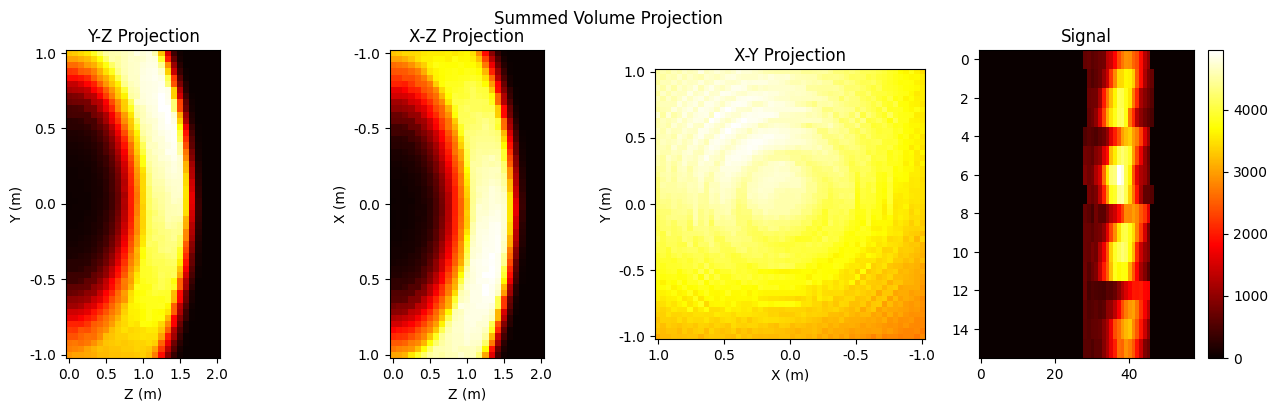

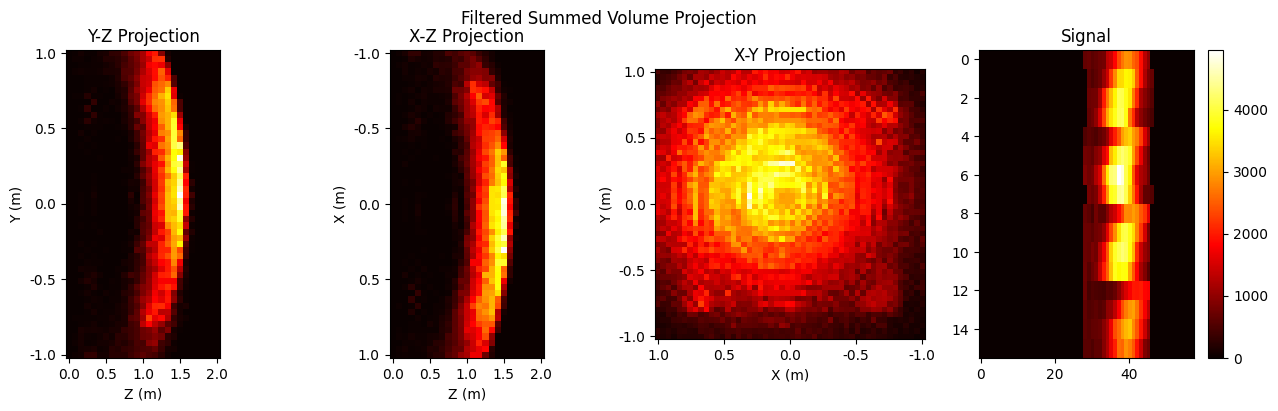

In [65]:
def plot_axis(
    volume: np.ndarray, axis: str, *, xlim: tuple[float, float], ylim: tuple[float, float], zlim: tuple[float, float], xres: float, yres: float, zres: float, num_x: int, num_y: int, num_z: int,
    points: list[np.ndarray] | None = None, gt: list[np.ndarray] | None = None,
    idx: int | None = None, **kwargs
) -> tuple [np.ndarray, float]:
    img: np.ndarray
    xnum, ynum = None, None
    val = None
    assert axis in ["x", "y", "z"], f"Invalid axis {axis}"
    if axis == "x":
        img = volume[idx, :, :].T if idx is not None else volume
        xlim, ylim = zlim, ylim
        xnum, ynum = num_z, num_y
        val = zlim[0] + (idx or 1) * zres
        xidx, yidx = 2, 1
    elif axis == "y":
        img = volume[:, idx, :].T if idx is not None else volume
        xlim, ylim = zlim, xlim
        xnum, ynum = num_z, num_x
        val = xlim[0] + (idx or 1) * xres
        xidx, yidx = 2, 0
    elif axis == "z":
        img = volume[:, :, idx].T if idx is not None else volume
        xlim, ylim = xlim, ylim
        xnum, ynum = num_x, num_y
        val = zlim[0] + (idx or 1) * zres
        xidx, yidx = 0, 1

    plt.imshow(img, **kwargs)

    xticks = np.round(np.linspace(0, xnum - 1, 5), 2)
    xlabels = np.round(np.linspace(xlim[0], xlim[1], 5), 2)
    plt.xticks(xticks, xlabels)

    yticks = np.round(np.linspace(0, ynum - 1, 5), 2)
    ylabels = np.round(np.linspace(ylim[0], ylim[1], 5), 2)
    plt.yticks(yticks, ylabels)

    points = [] if points is None else points
    for point in points:
        x = (point[xidx] - xlim[0]) / (xlim[1] - xlim[0]) * (num_x - 1)
        y = (point[yidx] - ylim[0]) / (ylim[1] - ylim[0]) * (num_y - 1)
        plt.plot(x, y, "og", markersize=10)

    gt = [] if gt is None else gt
    for gt_point in gt:
        x = (gt_point[xidx] - xlim[0]) / (xlim[1] - xlim[0]) * (num_x - 1)
        y = (gt_point[yidx] - ylim[0]) / (ylim[1] - ylim[0]) * (num_y - 1)
        plt.plot(x, y, "or", markersize=10)

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    return img, val

def plot_volume_slices(
    volume: np.ndarray,
    axis: str,
    title: str,
    *,
    num_cols: int = 5,
    **kwargs,
):
    import matplotlib.colors as mcolors

    kwargs.setdefault("cmap", "hot")
    kwargs.setdefault("norm", mcolors.PowerNorm(gamma=2))

    assert axis in ["x", "y", "z"], f"Invalid axis {axis}"
    num_plots = volume.shape["xyz".index(axis)]

    num_rows = np.ceil(num_plots / num_cols).astype(int)
    plt.figure(figsize=(3 * num_cols, 3 * num_rows))

    max_value = np.max(volume)
    volume = np.copy(volume) / np.max(volume) if max_value > 0 else volume
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i + 1)
        img, val = plot_axis(volume, axis, idx=i, **kwargs)
        plt.title(f"{axis} = {val:.2f} - Max: {np.max(img):.2f}")
        plt.clim([0, 1])

    plt.suptitle(title)

    # Add colorbar
    plt.colorbar()

def plot_volume_projection(
    volume: np.ndarray,
    title: str,
    gamma: int = 2,
    project_fn = np.max,
    fig: plt.Figure | None = None,
    signal: np.ndarray | None = None,
    **kwargs,
):
    import matplotlib.colors as mcolors

    kwargs.setdefault("cmap", "hot")
    kwargs.setdefault("norm", mcolors.PowerNorm(gamma=gamma))

    # normalize
    x_slice = project_fn(volume, axis=0)
    # x_slice = np.interp(x_slice, (x_slice.min(), x_slice.max()), (0, 1))
    y_slice = project_fn(volume, axis=1)
    # y_slice = np.interp(y_slice, (y_slice.min(), y_slice.max()), (0, 1))
    z_slice = project_fn(volume, axis=2)
    # z_slice = np.interp(z_slice, (z_slice.min(), z_slice.max()), (0, 1))

    num = 3 if signal is None else 4
    if fig is None:
        size = 4
        fig = plt.figure(figsize=(size * num, size))

    # Y-Z
    plt.subplot(1, num, 1)
    plot_axis(x_slice, "x", **kwargs)
    plt.title("Y-Z Projection")
    plt.xlabel("Z (m)")
    plt.ylabel("Y (m)")
    plt.gca().invert_xaxis()

    # X-Z
    plt.subplot(1, num, 2)
    plot_axis(y_slice, "y", **kwargs)
    plt.title("X-Z Projection")
    plt.ylabel("X (m)")
    plt.xlabel("Z (m)")
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    # X-Y
    plt.subplot(1, num, 3)
    plot_axis(z_slice.T, "z", **kwargs)
    plt.title("X-Y Projection")
    plt.ylabel("Y (m)")
    plt.xlabel("X (m)")

    # Signal
    if signal is not None:
        plt.subplot(1, num, 4)
        plt.imshow(np.clip(signal, 0, None), cmap="hot", aspect="auto")
        plt.title("Signal")

    plt.suptitle(title)

    plt.colorbar()

summed_volume = np.sum(bp_volumes, axis=0)
# summed_volume = bp_volumes[1].copy()
filtered_summed_volume = filter_volume(summed_volume, num_x, num_y)
# filtered_summed_volume = filter_volume(filtered_summed_volume, num_x, num_y)

print(hists_to_use.shape)
plot_volume_projection(
    summed_volume,
    title="Summed Volume Projection",
    signal=hists_to_use.mean(axis=0),
    xlim=x_range,
    ylim=y_range,
    zlim=z_range,
    xres=x_res,
    yres=y_res,
    zres=z_res,
    num_x=num_x,
    num_y=num_y,
    num_z=num_z,
    # points=np.mean(object2origin_to_use[:, :3, 3], axis=0, keepdims=True),
    # gt=[best_summed_point]
)
plot_volume_projection(
    filtered_summed_volume,
    title="Filtered Summed Volume Projection",
    signal=hists_to_use.mean(axis=0),
    xlim=x_range,
    ylim=y_range,
    zlim=z_range,
    xres=x_res,
    yres=y_res,
    zres=z_res,
    num_x=num_x,
    num_y=num_y,
    num_z=num_z,
    # points=np.mean(object2origin_to_use[:, :3, 3], axis=0, keepdims=True),
    # gt=[best_filtered_point]
)

In [ ]:
summed_volume = np.sum(bp_volumes, axis=0)
filtered_summed_volume = filter_volume(summed_volume, num_x, num_y)
# filtered_summed_volume = filter_volume(filtered_summed_volume, num_x, num_y)

plot_volume_projection(
    summed_volume,
    title="Summed Volume Projection",
    signal=hists_to_use.mean(axis=0),
    xlim=x_range,
    ylim=y_range,
    zlim=z_range,
    xres=x_res,
    yres=y_res,
    zres=z_res,
    num_x=num_x,
    num_y=num_y,
    num_z=num_z,
    # points=np.mean(object2origin_to_use[:, :3, 3], axis=0, keepdims=True),
    # gt=[best_summed_point]
)
plot_volume_projection(
    filtered_summed_volume,
    title="Filtered Summed Volume Projection",
    signal=hists_to_use.mean(axis=0),
    xlim=x_range,
    ylim=y_range,
    zlim=z_range,
    xres=x_res,
    yres=y_res,
    zres=z_res,
    num_x=num_x,
    num_y=num_y,
    num_z=num_z,
    # points=np.mean(object2origin_to_use[:, :3, 3], axis=0, keepdims=True),
    # gt=[best_filtered_point]
)